# Regression

## Objectives :
Memprediksi total quantity harian dari product yang terjual menggunakan model machine learning ARIMA.

## Import Library

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Import Data

In [13]:
df_customer = pd.read_csv('/content/Case Study - Customer.csv', sep=';')
df_product = pd.read_csv('/content/Case Study - Product.csv', sep=';')
df_store = pd.read_csv('/content/Case Study - Store.csv', sep=';')
df_transaction = pd.read_csv('/content/Case Study - Transaction.csv', sep=';')
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-62,106816666
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6914864,107608238
2,3,Prima Kota,Prima,Modern Trade,-7797068,110370529
3,4,Gita Ginara,Gita,General Trade,-6966667,110416664
4,5,Bonafid,Gita,General Trade,-7250445,112768845


## Data Preprocessing

In [14]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 17.6+ KB


In [15]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [16]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     int64 
 5   Longitude   14 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 800.0+ bytes


In [17]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [18]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format="%d/%m/%Y")

In [19]:
df_transaction['CustomerID'] = df_transaction['CustomerID'].astype(str)
df_transaction['StoreID'] = df_transaction['StoreID'].astype(str)
df_store['StoreID'] = df_store['StoreID'].astype(str)
df_customer['CustomerID'] = df_customer['CustomerID'].astype(str)

In [20]:
df_merged = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merged = pd.merge(df_merged, df_product.drop(columns=['Price']), on=['ProductID'])
df_merged = pd.merge(df_merged, df_store, on=['StoreID'])

In [21]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10,Crackers,Prestasi Utama,Prestasi,General Trade,-2990934,104756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0,Crackers,Prestasi Utama,Prestasi,General Trade,-2990934,104756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4,Crackers,Prestasi Utama,Prestasi,General Trade,-2990934,104756554
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4,Crackers,Prestasi Utama,Prestasi,General Trade,-2990934,104756554
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9,Crackers,Prestasi Utama,Prestasi,General Trade,-2990934,104756554


In [11]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   object        
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   object        
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          5020 non-null   int64         
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

In [ ]:
df_regresi = df_merged.groupby(['Date']).agg({'Qty' : 'sum'}).reset_index()

In [ ]:
df_regresi.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30


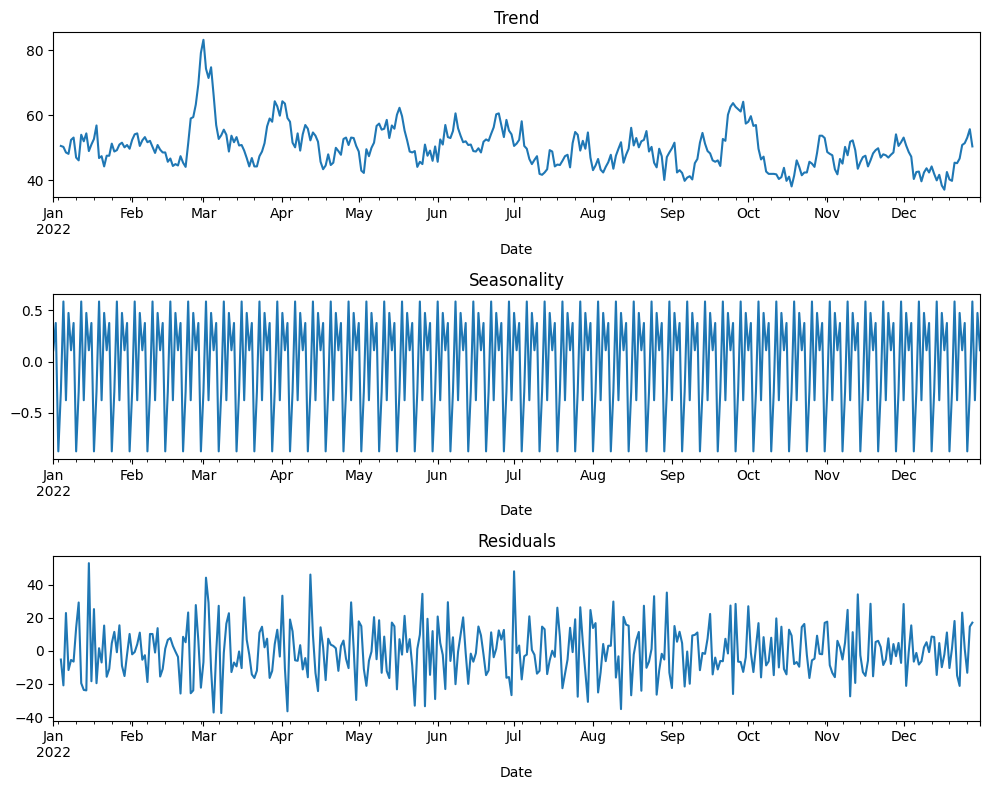

In [ ]:
decomposed = seasonal_decompose(df_regresi.set_index(['Date']))

plt.figure(figsize=(10,8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [ ]:
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

<Axes: xlabel='Date', ylabel='Qty'>

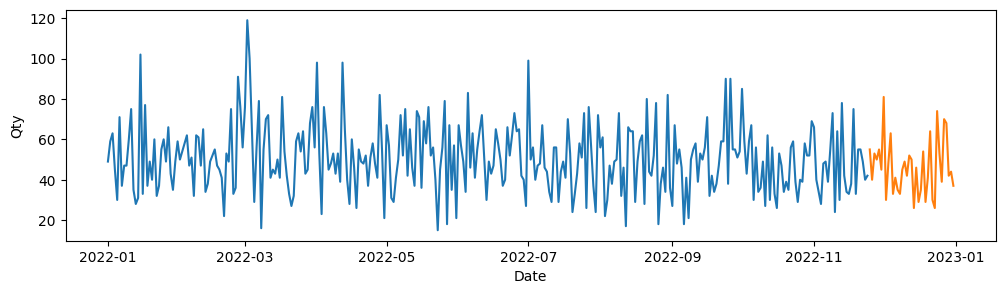

In [ ]:
plt.figure(figsize=(12,3))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

## Modeling

In [ ]:
res = adfuller(df_regresi['Qty'].dropna())
print('Augmented Dickey-Fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

Augmented Dickey-Fuller Statistic: -19.448086
p-value: 0.000000


The ADF test's p-value is less than the significance level (0.05), then we will reject the null hypothesis and infer that the time series is definitely stationary.

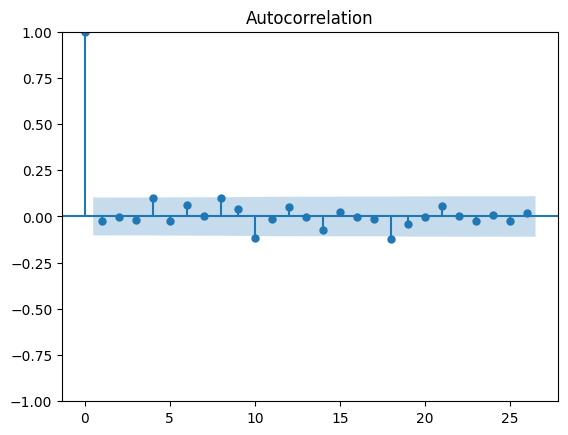

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


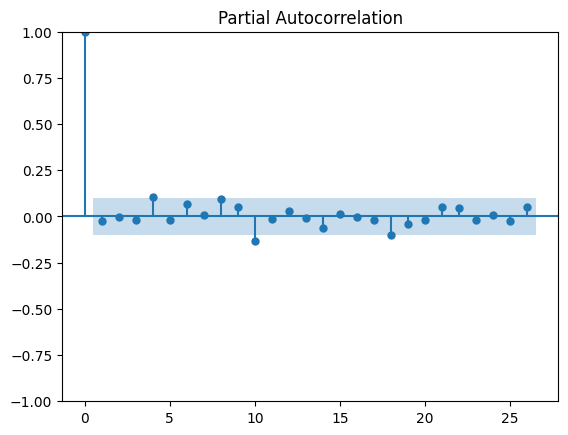

In [ ]:
plot_acf(df_regresi['Qty'])
plt.show()
plot_pacf(df_regresi['Qty'])
plt.show()

In [ ]:
def rmse(y_actual, y_pred):
  print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

In [ ]:
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE value 14.32852897119205
MAE value 11.451785678925047


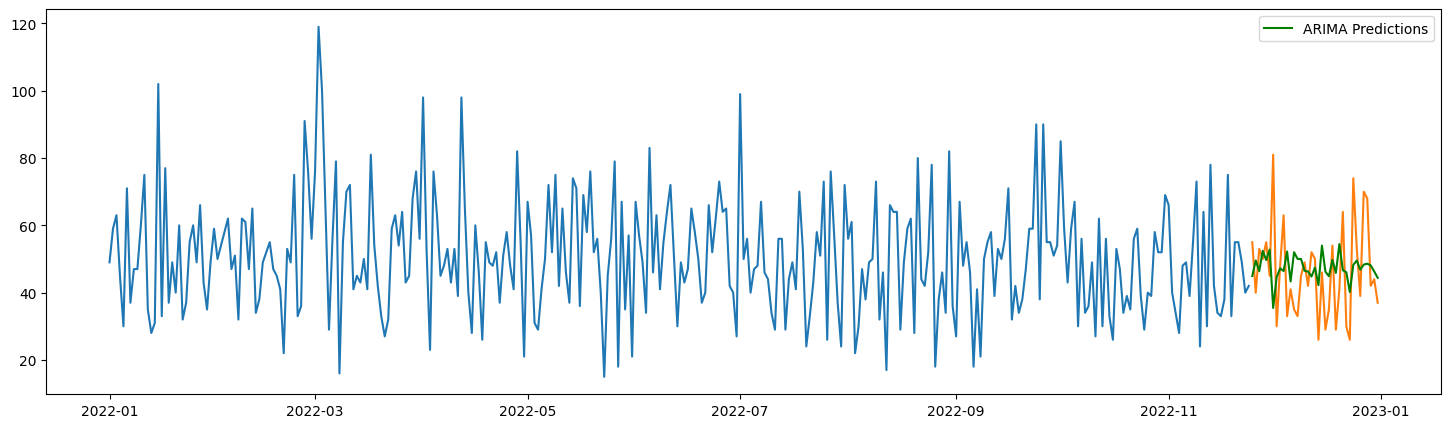

In [ ]:
y = df_train['Qty']

ARIMA_model = sm.tsa.arima.ARIMA(y, order=(37,1,0))
ARIMA_model = ARIMA_model.fit()

y_pred = ARIMA_model.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMA_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(18,5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'])
plt.plot(y_pred_out, color='green', label='ARIMA Predictions')
plt.legend()

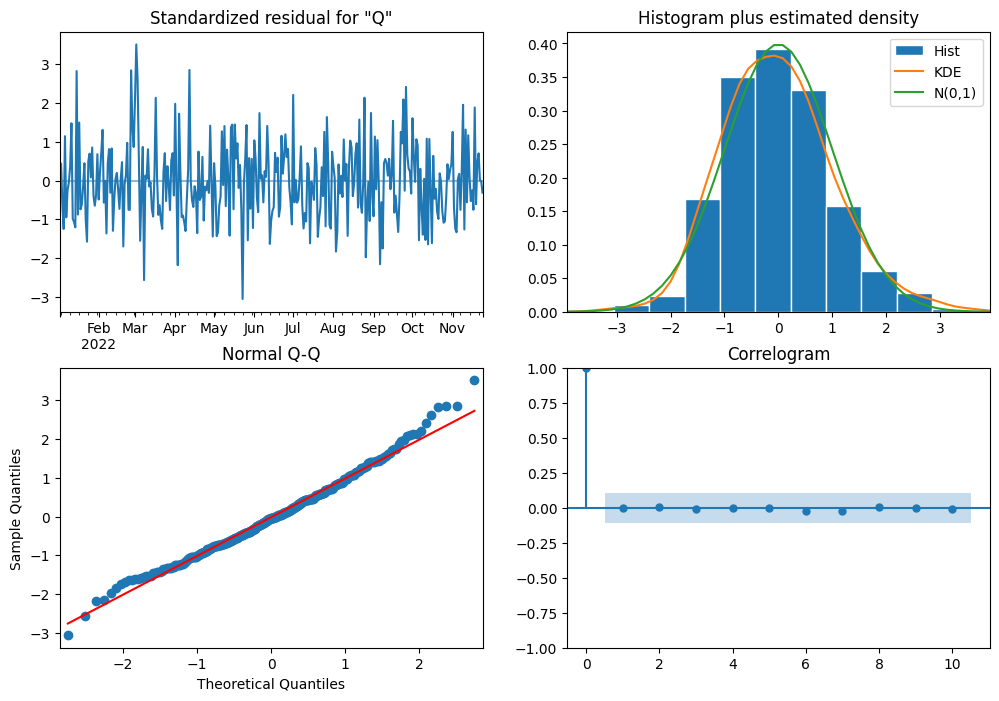

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(12,8))
plt.show()

# Clustering

## Data Preprocessing

In [24]:
df_cluster = df_merged.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum',
    'Age' : 'mean',
    'Gender' : 'mean',
    'Income' : 'mean'
    }).reset_index()

In [26]:
df_cluster.head()

,CustomerID,TransactionID,Qty,TotalAmount,Age,Gender,Income
0,1,17,60,623300,55.0,1.0,5.0
1,10,14,50,478000,34.0,1.0,4.0
2,100,8,35,272400,45.0,1.0,6.0
3,101,14,44,439600,61.0,1.0,54.0
4,102,15,57,423300,39.0,0.0,6.0


In [27]:
df_cluster.drop(['CustomerID'], axis=1, inplace=True)

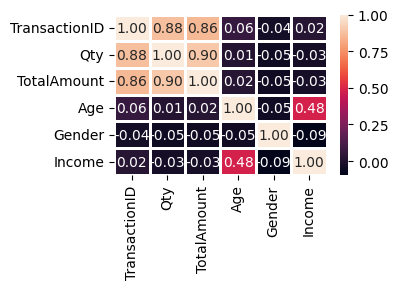

In [28]:
plt.figure(figsize=(4,3))
sns.heatmap(df_cluster.corr(), annot=True, fmt='.2f', linewidth=1)
plt.tight_layout()
plt.show()

In [29]:
df_cluster['F'] = df_cluster['TransactionID']
df_cluster['M'] = df_cluster['TotalAmount']
df_cluster['Q'] = df_cluster['Qty']

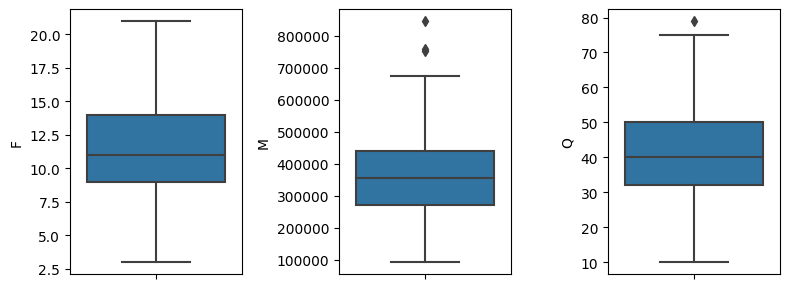

In [30]:
cols = ['F', 'M', 'Q']
plt.figure(figsize=(8, 3))
for i in range(len(cols)):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df_cluster[cols[i]])
    plt.tight_layout()

In [31]:
df_scaled = df_cluster.filter(['F', 'M', 'Q'])

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns=['F', 'M', 'Q'])
df_scaled.head()

,F,M,Q
0,0.777778,0.703949,0.724638
1,0.611111,0.511397,0.579710
2,0.277778,0.238935,0.362319
3,0.611111,0.460509,0.492754
4,0.666667,0.438908,0.681159


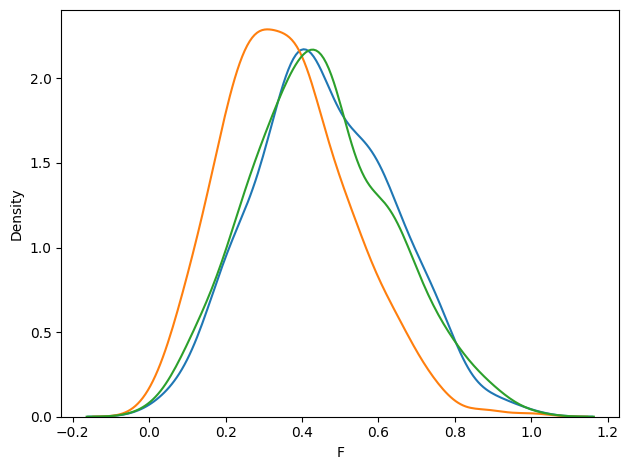

In [36]:
sns.kdeplot(df_scaled['F'])
sns.kdeplot(df_scaled['M'])
sns.kdeplot(df_scaled['Q'])
plt.tight_layout()

In [37]:
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
F,447.0,0.457246,0.180295,0.0,0.333333,0.444444,0.611111,1.0
M,447.0,0.358352,0.165166,0.0,0.238073,0.347336,0.462629,1.0
Q,447.0,0.448270,0.184879,0.0,0.318841,0.434783,0.579710,1.0


## Modeling

In [38]:
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

<Axes: title={'center': 'Inertia Evaluation Score'}>

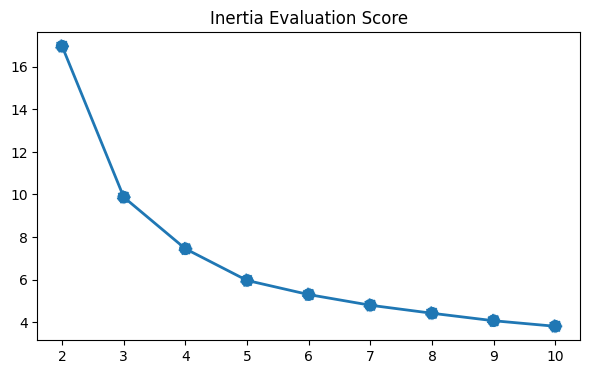

In [39]:
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)#, random_state=0)
    kmeans.fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(7,4))
plt.title('Inertia Evaluation Score', fontsize=12)
sns.lineplot(x=range(2, 11), y=inertia, linewidth = 2)
sns.scatterplot(x=range(2, 11), y=inertia, s=100, linestyle='--')

In [40]:
(pd.Series(inertia) - pd.Series(inertia).shift(-1)) / pd.Series(inertia) * 100

0    41.820327
1    24.569020
2    19.983618
3    11.148203
4     9.463713
5     7.862818
6     7.972540
7     6.408060
8          NaN
dtype: float64

In [41]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_scaled)
df_scaled['cluster'] = kmeans.labels_

df_clustering = df_cluster.filter(['TransactionID','TotalAmount','Qty'])
df_clustering.columns = ['F', 'M', 'Q']
df_clustering['cluster'] = kmeans.labels_

In [42]:
pca = PCA(n_components=2)

pca.fit(df_scaled)
pcs = pca.transform(df_scaled)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca['cluster'] = df_scaled['cluster']
df_pca.sample(10)

,PC 1,PC 2,cluster
277,0.140774,0.464102,1
304,0.160227,0.347407,1
358,0.178468,0.236334,1
359,1.274646,-0.260944,2
439,1.235668,-0.029750,2
338,-0.767079,-0.175792,0
392,0.158601,0.358132,1
251,0.176917,0.244285,1
275,1.245131,-0.085678,2
445,-0.796230,0.003881,0


## Visualization

<Axes: title={'center': '2-D Visualization of Customer Clusters\nWih PCA'}, xlabel='PC 2', ylabel='PC 1'>

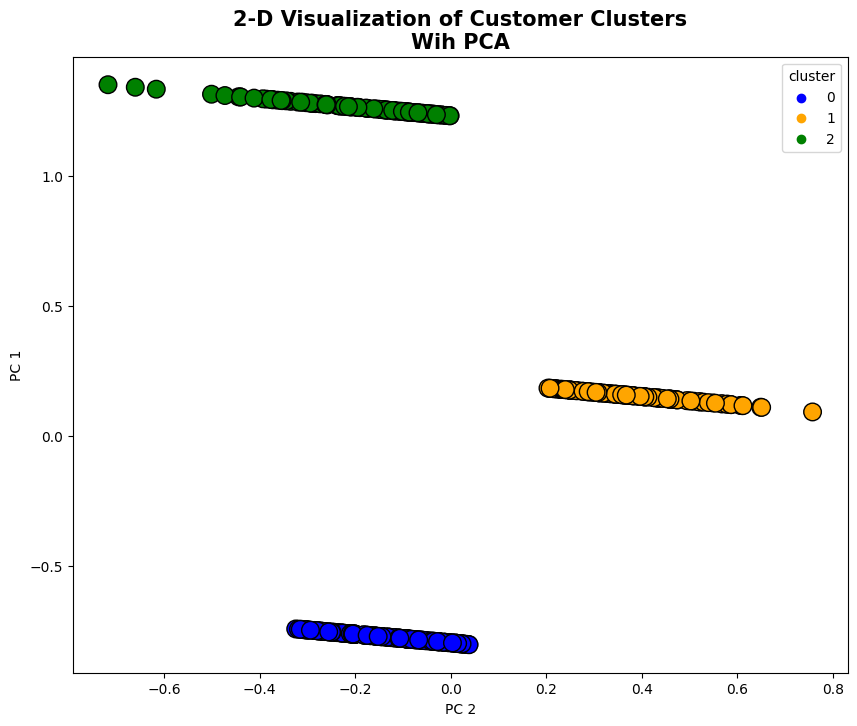

In [43]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("2-D Visualization of Customer Clusters\nWih PCA", fontsize=15, weight='bold')
sns.scatterplot(y="PC 1",
                x="PC 2",
                hue="cluster",
                edgecolor='black',
                data=df_pca,
                palette=['blue','orange','green'],
                s=160,
                ax=ax)

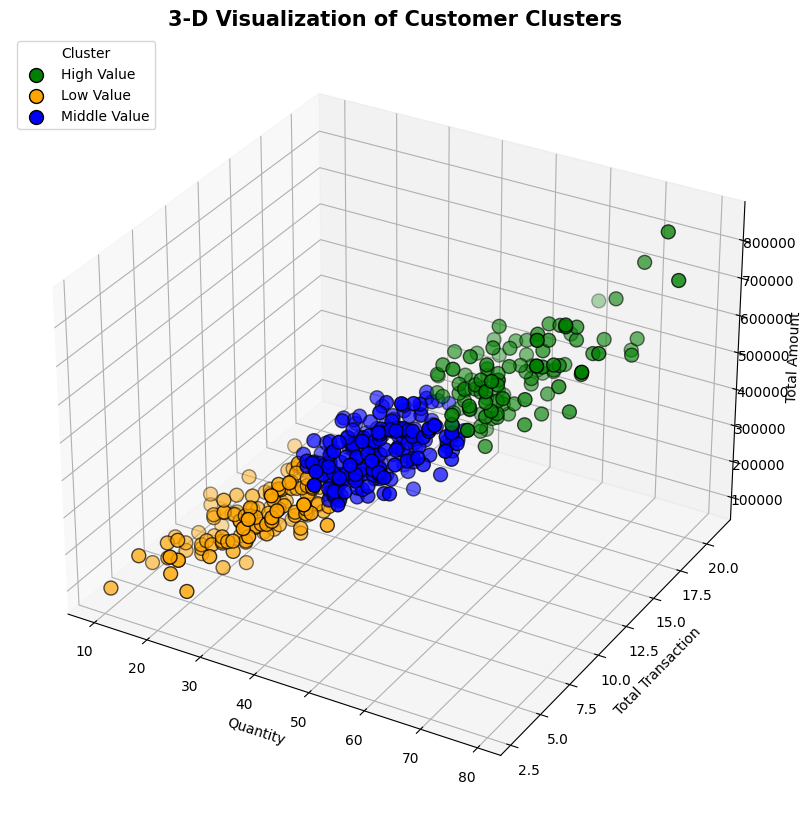

In [44]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("3-D Visualization of Customer Clusters", fontsize=15, weight='bold')
ax.scatter(df_clustering['Q'][df_clustering.cluster == 2], df_clustering['F'][df_clustering.cluster == 2], df_clustering['M'][df_clustering.cluster == 2], c='green', s=100, edgecolor='black', label='High Value')
ax.scatter(df_clustering['Q'][df_clustering.cluster == 1], df_clustering['F'][df_clustering.cluster == 1], df_clustering['M'][df_clustering.cluster == 1], c='orange', s=100, edgecolor='black', label='Low Value')
ax.scatter(df_clustering['Q'][df_clustering.cluster == 0], df_clustering['F'][df_clustering.cluster == 0], df_clustering['M'][df_clustering.cluster == 0], c='blue', s=100, edgecolor='black', label='Middle Value')

plt.xlabel('Quantity')
plt.ylabel('Total Transaction')
ax.set_zlabel('Total Amount')
plt.legend(title='Cluster', loc='upper left')
plt.show()

## Interpretation

In [45]:
df_cluster['Cluster'] = kmeans.labels_

In [46]:
df_cluster.head(5)

,TransactionID,Qty,TotalAmount,Age,Gender,Income,F,M,Q,Cluster
0,17,60,623300,55.0,1.0,5.0,17,623300,60,2
1,14,50,478000,34.0,1.0,4.0,14,478000,50,2
2,8,35,272400,45.0,1.0,6.0,8,272400,35,1
3,14,44,439600,61.0,1.0,54.0,14,439600,44,0
4,15,57,423300,39.0,0.0,6.0,15,423300,57,2


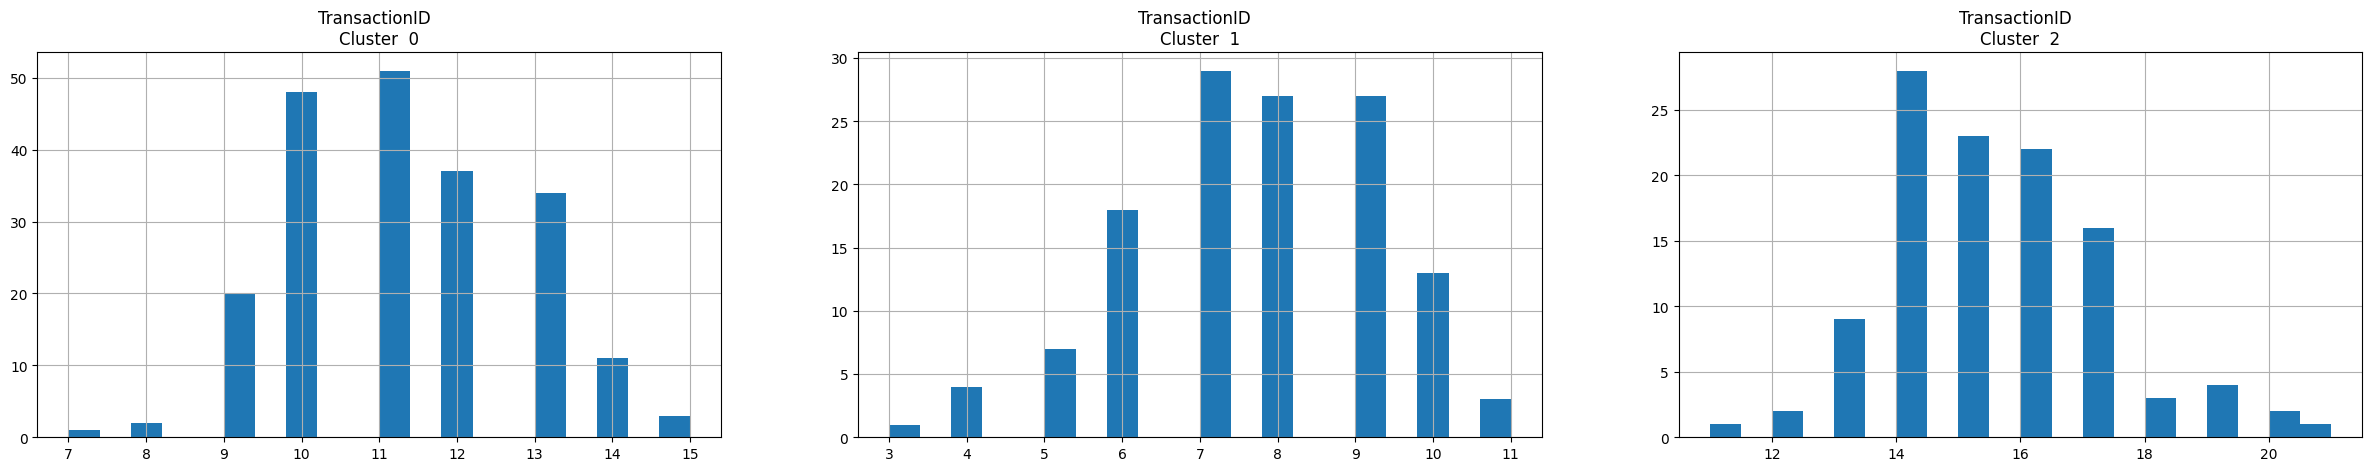

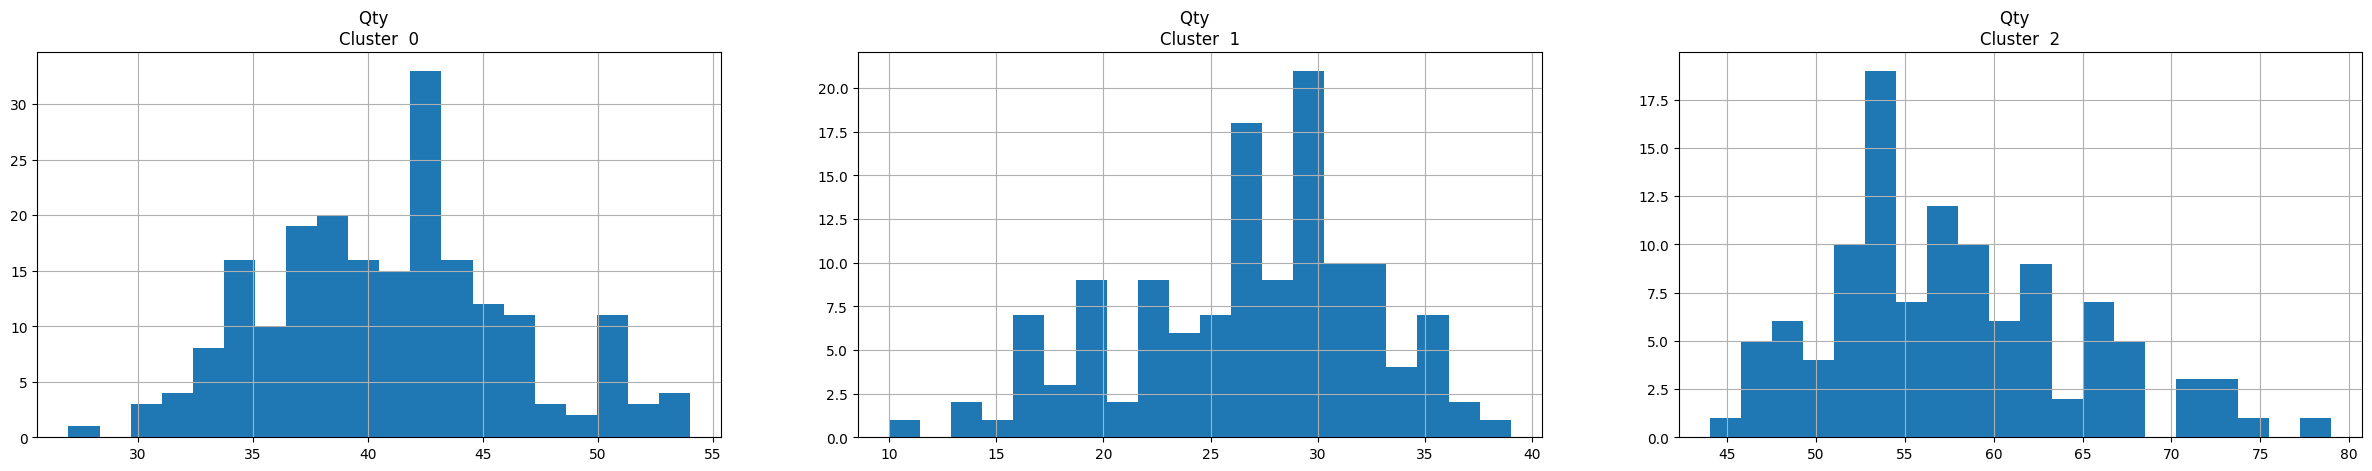

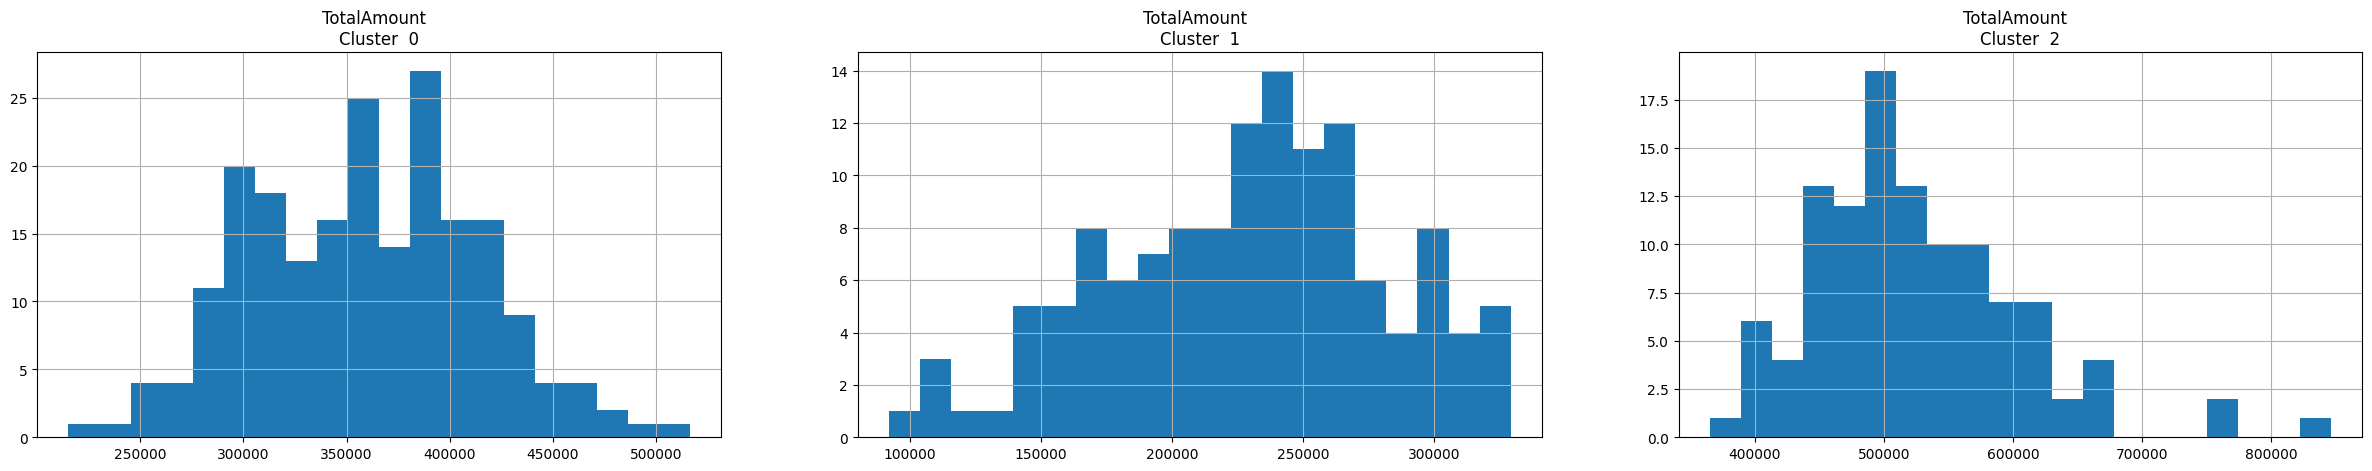

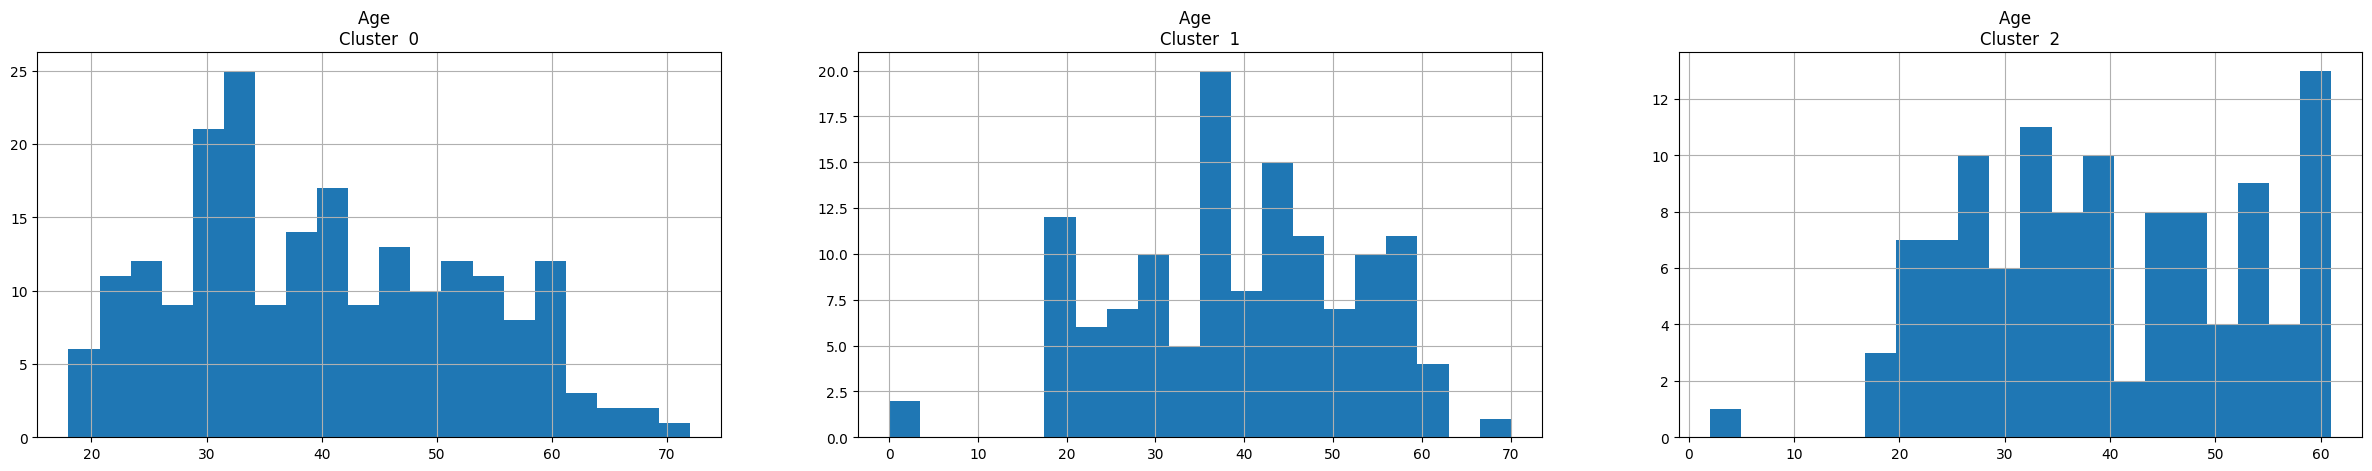

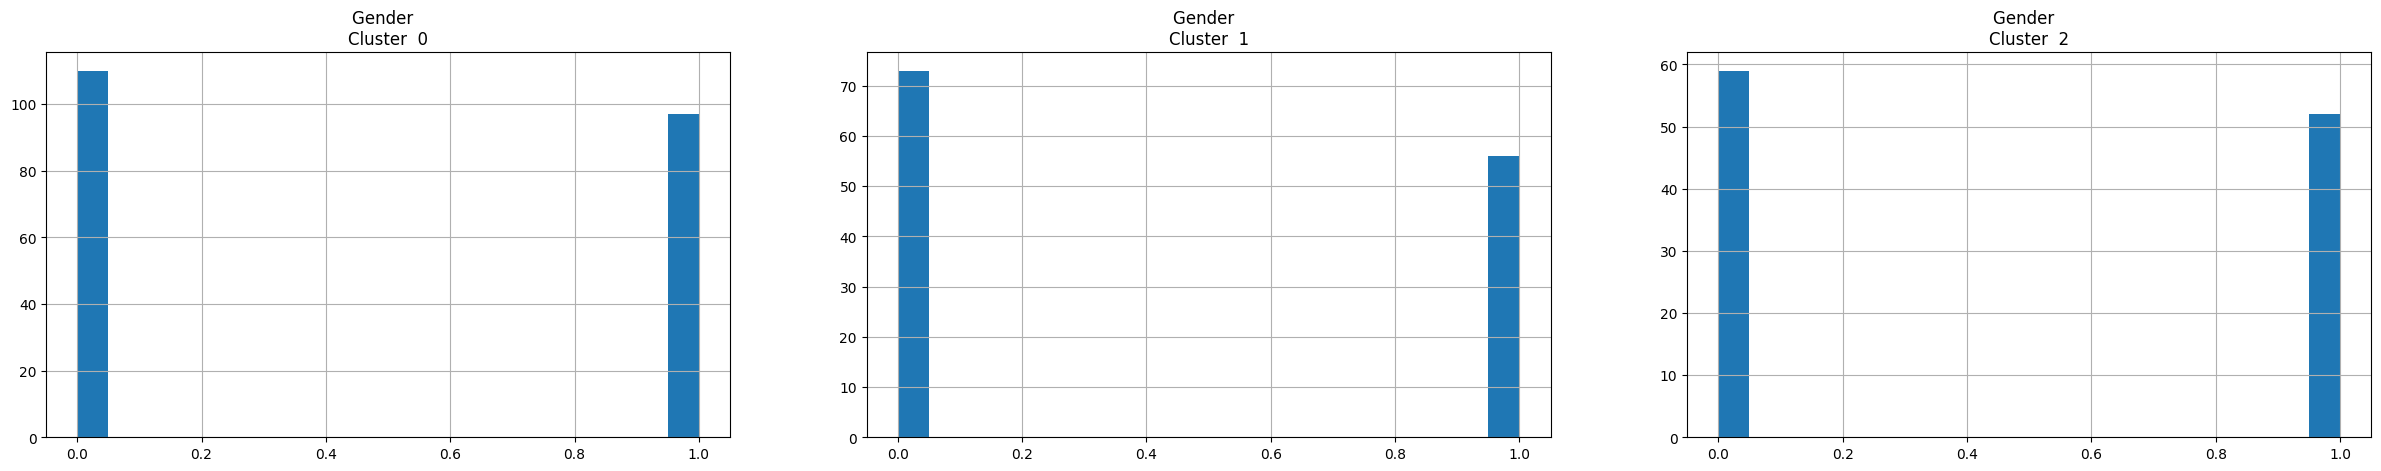

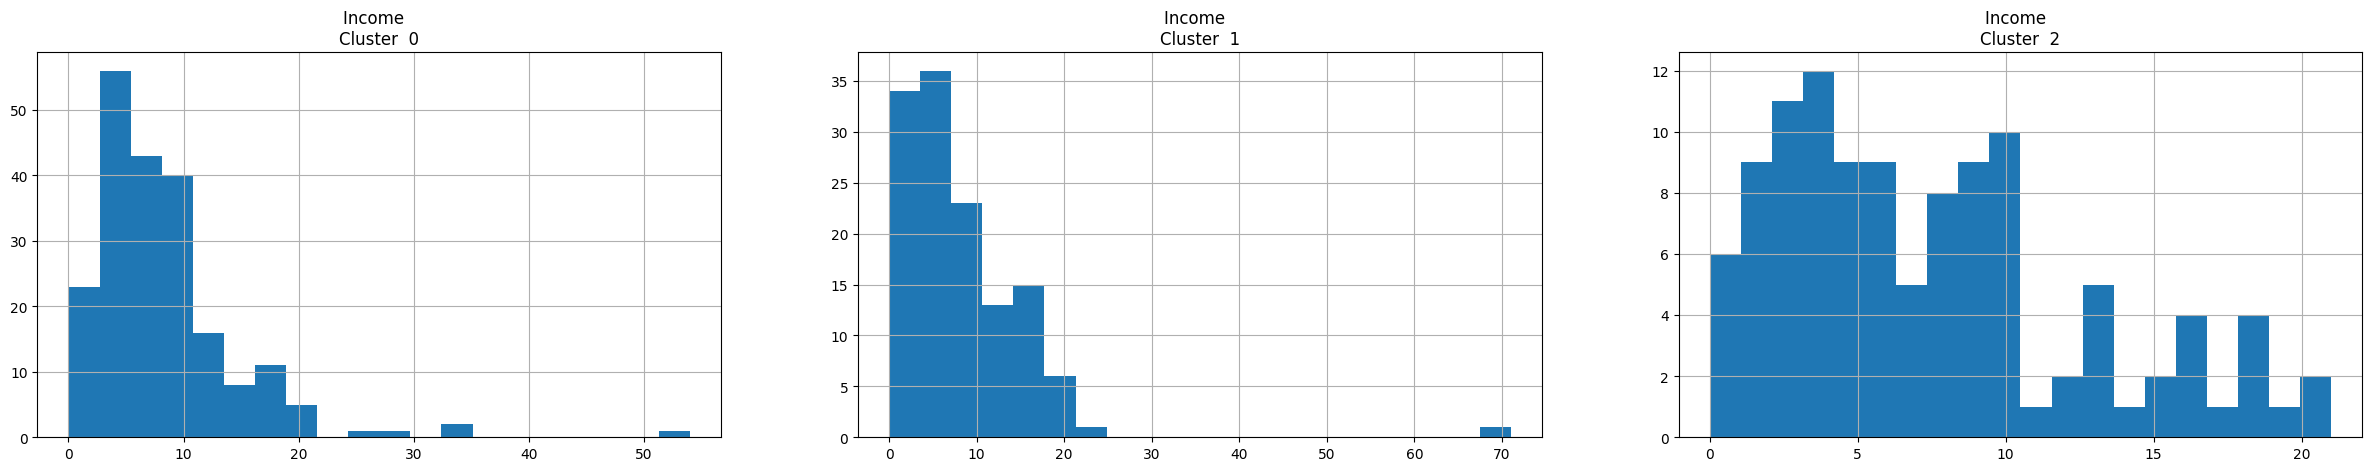

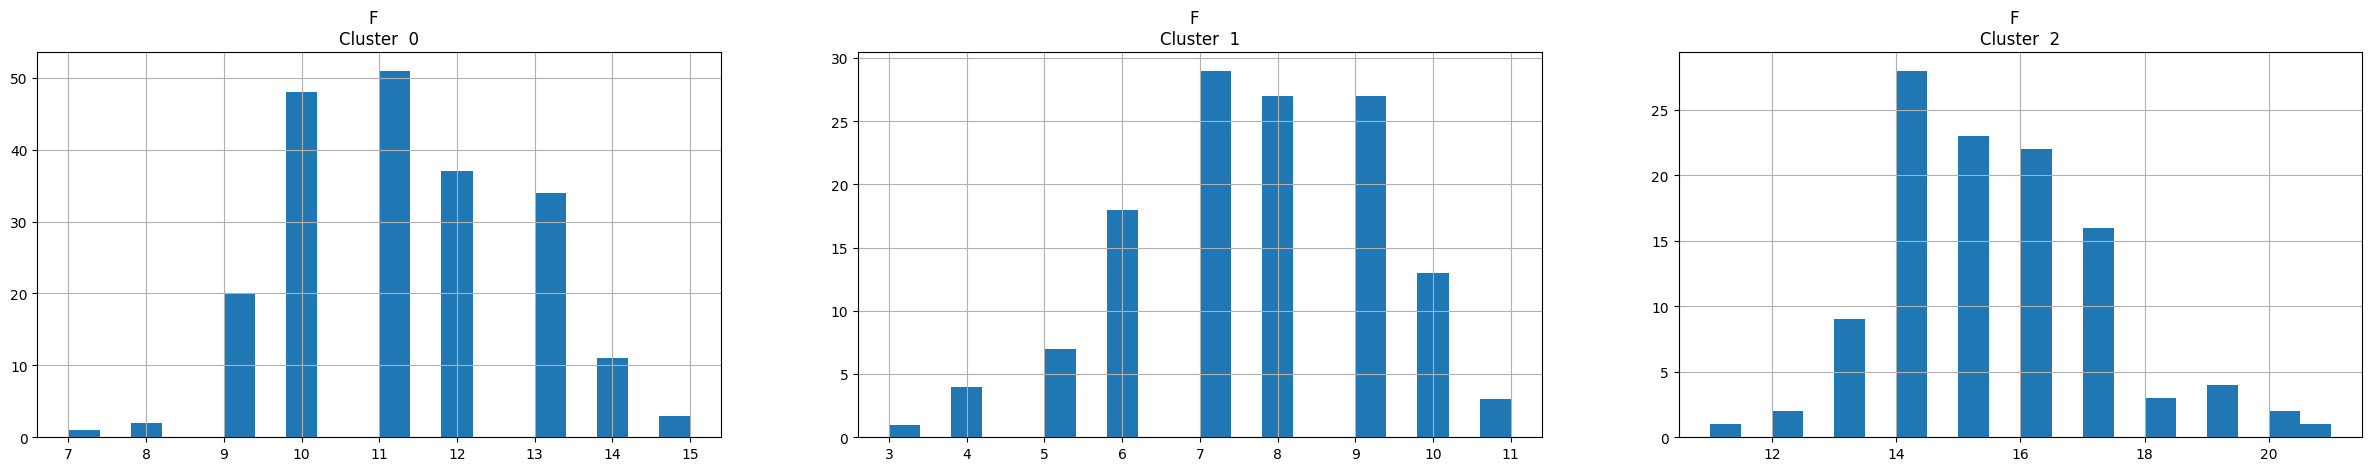

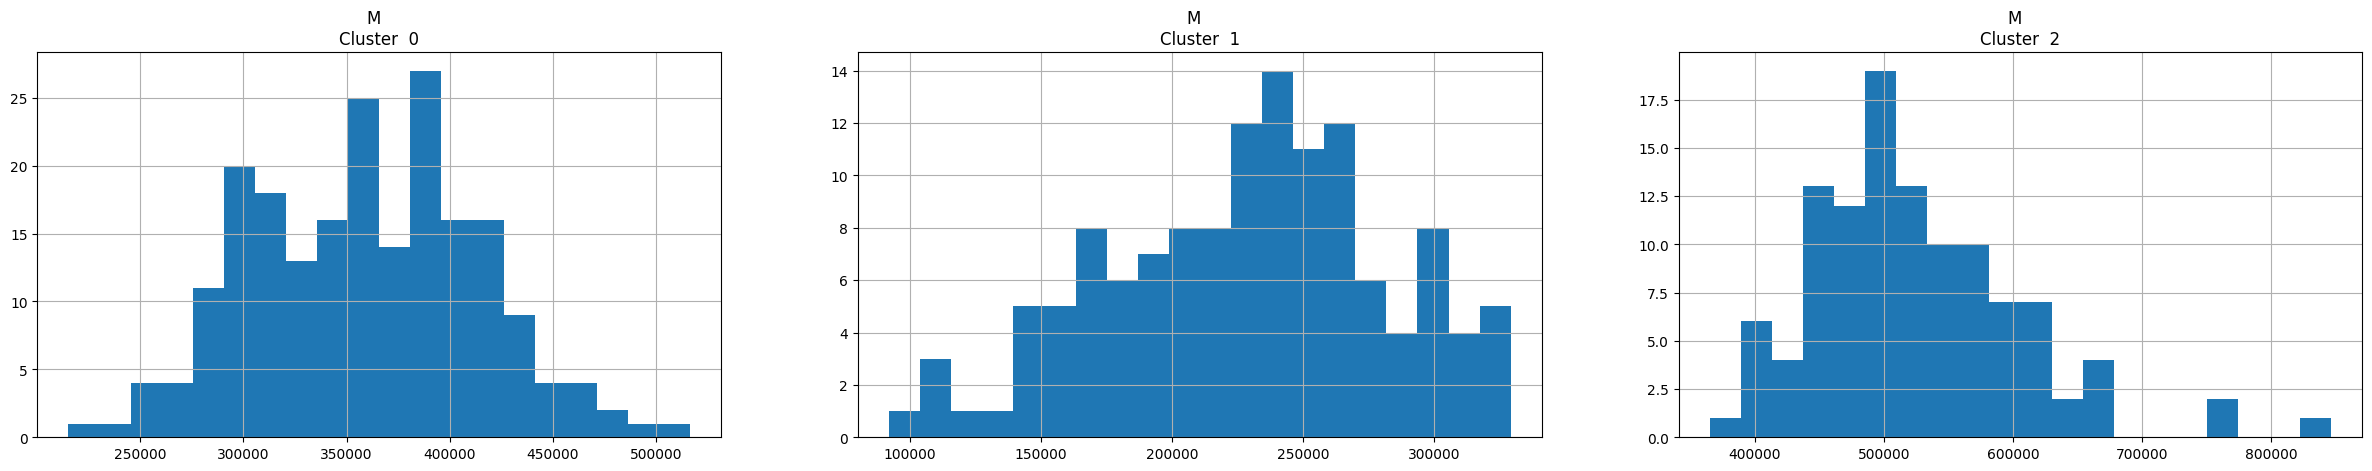

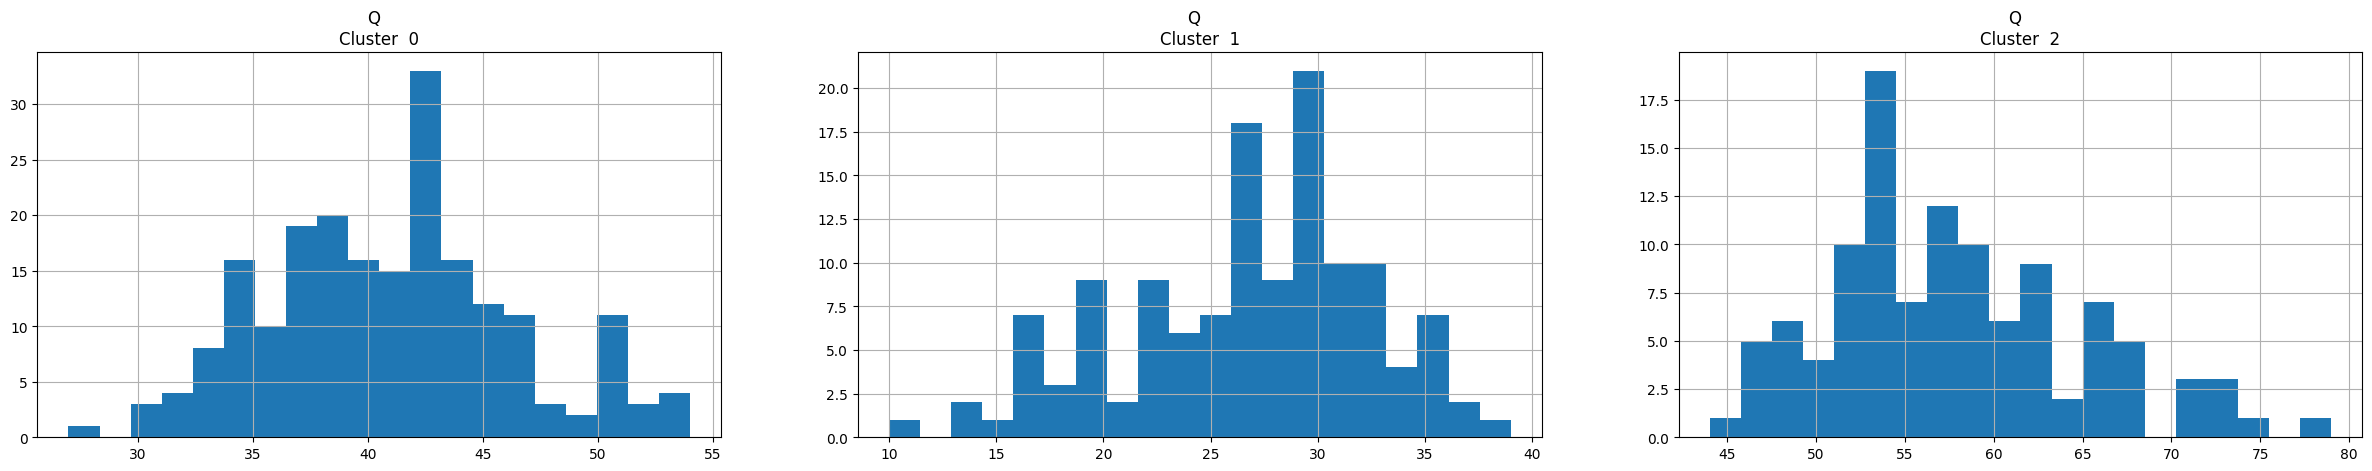

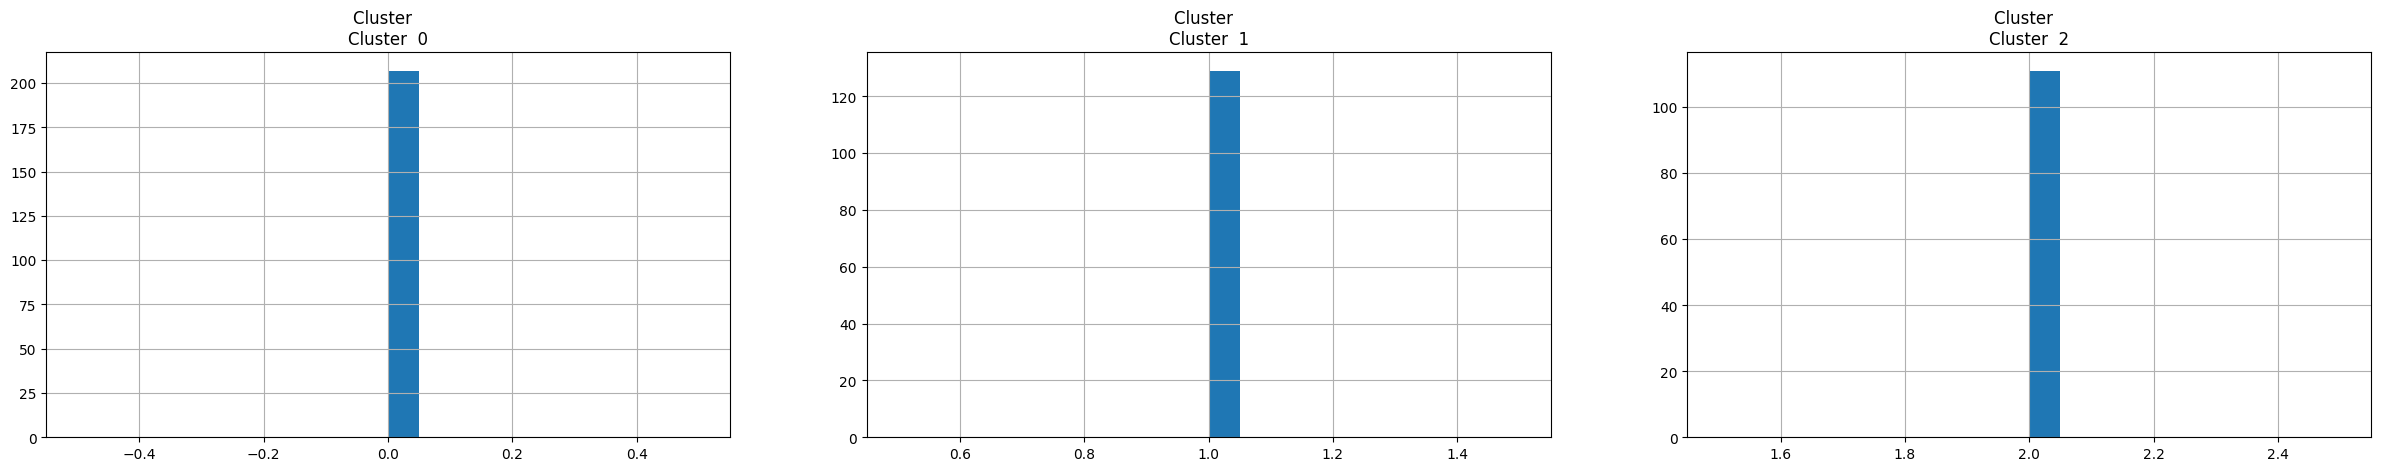

In [47]:
for i in df_cluster.columns:
    plt.figure(figsize=(30,5))
    for j in range(3):
        plt.subplot(1,3,j+1)
        cluster = df_cluster[df_cluster['Cluster']==j]
        cluster[i].hist(bins=20)
        plt.title('{}  \nCluster  {}'.format(i,j))

    plt.show()

In [48]:
num_cols = ['TransactionID', 'Qty', 'TotalAmount']
#cat_cols = df.select_dtypes(include = ['object','category']).columns

In [49]:
display(df_cluster.groupby(['Cluster']).describe())

TransactionID                                                     \
                count       mean       std   min   25%   50%   75%   max   
Cluster                                                                    
0               207.0  11.251208  1.508772   7.0  10.0  11.0  12.0  15.0   
1               129.0   7.651163  1.637696   3.0   7.0   8.0   9.0  11.0   
2               111.0  15.351351  1.776865  11.0  14.0  15.0  16.0  21.0   

           Qty                                                    TotalAmount  \
         count       mean       std   min   25%   50%   75%   max       count   
Cluster                                                                         
0        207.0  40.917874  5.270178  27.0  37.0  41.0  44.0  54.0       207.0   
1        129.0  26.643411  5.818610  10.0  22.0  27.0  31.0  39.0       129.0   
2        111.0  57.558559  7.071948  44.0  53.0  57.0  62.0  79.0       111.0   

                                                                              \
                  mean           std       min       25%       50%       75%   
Cluster                                                                        
0        359791.787440  55574.207192  215100.0  315600.0  360400.0  397550.0   
1        228289.922481  53146.266104   92100.0  189600.0  233800.0  263700.0   
2        523573.873874  81200.111634  365000.0  470500.0  509900.0  574300.0   

                     Age                                                      \
              max  count       mean        std   min   25%   50%   75%   max   
Cluster                                                                        
0        516600.0  207.0  40.125604  12.418811  18.0  31.0  38.0  50.0  72.0   
1        329300.0  129.0  39.387597  13.241926   0.0  30.0  39.0  49.0  70.0   
2        846700.0  111.0  39.603604  13.268746   2.0  28.5  39.0  51.0  61.0   

        Gender                                              Income            \
         count      mean       std  min  25%  50%  75%  max  count      mean   
Cluster                                                                        
0        207.0  0.468599  0.500223  0.0  0.0  0.0  1.0  1.0  207.0  8.154589   
1        129.0  0.434109  0.497572  0.0  0.0  0.0  1.0  1.0  129.0  8.527132   
2        111.0  0.468468  0.501268  0.0  0.0  0.0  1.0  1.0  111.0  7.540541   

                                                  F                       \
              std  min  25%  50%   75%   max  count       mean       std   
Cluster                                                                    
0        6.545974  0.0  4.0  7.0  10.0  54.0  207.0  11.251208  1.508772   
1        7.705596  0.0  3.0  7.0  12.0  71.0  129.0   7.651163  1.637696   
2        5.012319  0.0  4.0  6.0  10.0  21.0  111.0  15.351351  1.776865   

                                           M                               \
          min   25%   50%   75%   max  count           mean           std   
Cluster                                                                     
0         7.0  10.0  11.0  12.0  15.0  207.0  359791.787440  55574.207192   
1         3.0   7.0   8.0   9.0  11.0  129.0  228289.922481  53146.266104   
2        11.0  14.0  15.0  16.0  21.0  111.0  523573.873874  81200.111634   

                                                               Q             \
              min       25%       50%       75%       max  count       mean   
Cluster                                                                       
0        215100.0  315600.0  360400.0  397550.0  516600.0  207.0  40.917874   
1         92100.0  189600.0  233800.0  263700.0  329300.0  129.0  26.643411   
2        365000.0  470500.0  509900.0  574300.0  846700.0  111.0  57.558559   

                                                 
              std   min   25%   50%   75%   max  
Cluster                                          
0        5.270178  27.0  37.0  41.0  44.0  54.0  
1        5.818610  10.0  2

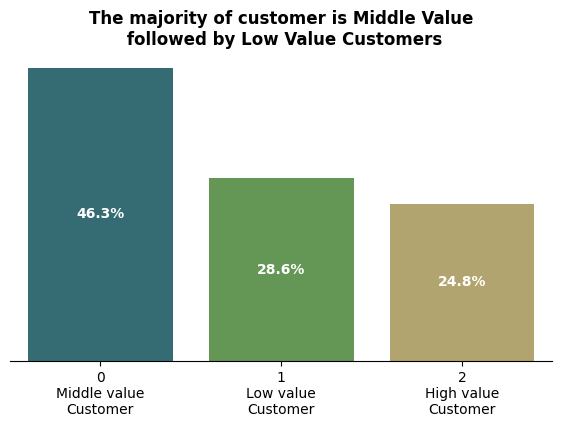

In [50]:
customer = df_cluster.groupby('Cluster')['Cluster'].count()/len(df_cluster)
customer = customer.to_frame().rename(columns={'Cluster':'%Customer'}).sort_values(by='%Customer',ascending=False).reset_index()

plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Cluster', y='%Customer', data=customer, palette='gist_earth')
plt.title('The majority of customer is Middle Value\n followed by Low Value Customers', fontweight='bold')
plt.bar_label(ax.containers[0], ['46.3%', '28.6%', '24.8%'], label_type='center',
             color='white', fontweight='bold')
plt.xticks(np.arange(3), ['0\nMiddle value\nCustomer', '1\nLow value\nCustomer', '2\nHigh value\nCustomer'])
plt.yticks(None)
plt.xlabel(None)
ax.axes.yaxis.set_visible(False)
sns.despine(left=True)

Text(0, 0.5, 'Total Amount')

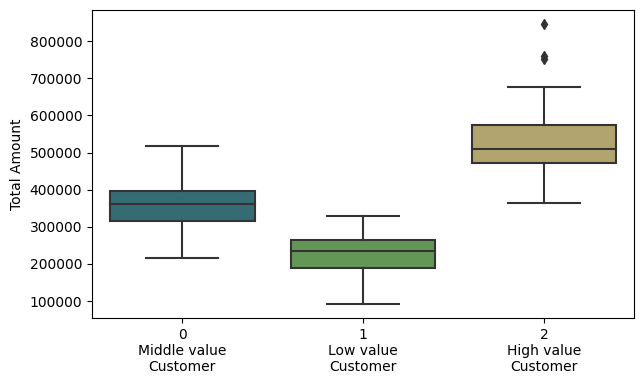

In [51]:
plt.figure(figsize=(7, 4))
ax = sns.boxplot(y=df_cluster['TotalAmount'], x=df_cluster['Cluster'], palette='gist_earth')
plt.xticks(np.arange(3), ['0\nMiddle value\nCustomer', '1\nLow value\nCustomer', '2\nHigh value\nCustomer'])
plt.xlabel(None)
plt.ylabel('Total Amount')

Text(0, 0.5, 'Total Transaction')

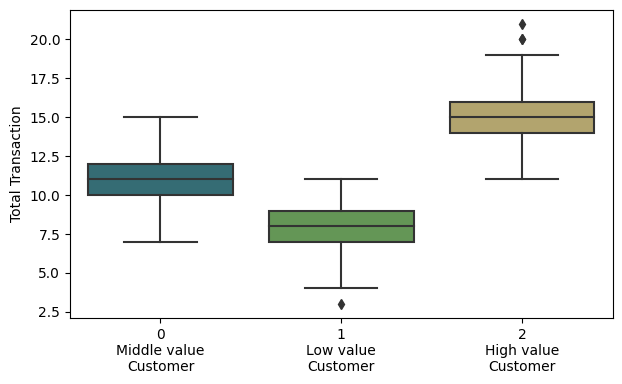

In [52]:
plt.figure(figsize=(7, 4))
ax = sns.boxplot(y=df_cluster['TransactionID'], x=df_cluster['Cluster'], palette='gist_earth')
plt.xticks(np.arange(3), ['0\nMiddle value\nCustomer', '1\nLow value\nCustomer', '2\nHigh value\nCustomer'])
plt.xlabel(None)
plt.ylabel('Total Transaction')

Text(0, 0.5, 'Quantity')

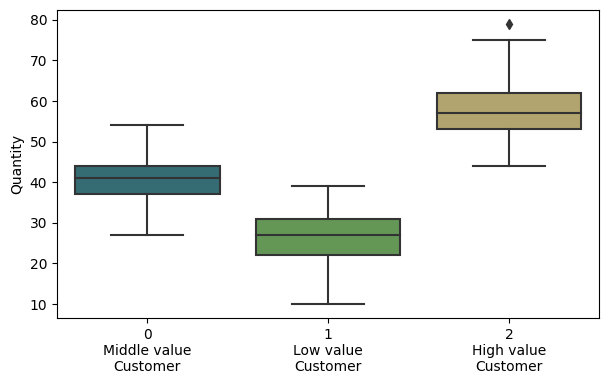

In [53]:
plt.figure(figsize=(7, 4))
ax = sns.boxplot(y=df_cluster['Qty'], x=df_cluster['Cluster'], palette='gist_earth')
plt.xticks(np.arange(3), ['0\nMiddle value\nCustomer', '1\nLow value\nCustomer', '2\nHigh value\nCustomer'])
plt.xlabel(None)
plt.ylabel('Quantity')